# 📊 demo_inference.ipynb

## Overview

This notebook demonstrates how to **load a trained Vision Transformer (ViT) model** for plant disease classification and perform inference on sample images. It is designed as an **inference demo** for the [MLOps Plant Disease Classifier project](https://github.com/mcherif/plant-disease-mlops).

## Intent

- **Showcase end-to-end inference** with a finetuned ViT model on local plant leaf images.
- **Verify model deployment** and local serving, ensuring the best model is correctly saved and can be reused.
- **Provide a user-friendly template** for running new predictions or integrating with a web/app interface.

## Features

- Loads the finetuned model and processor from the local `models/vit-finetuned` directory.
- Accepts single or batch image inputs.
- Outputs predicted plant disease labels (and optionally confidence scores).
- Includes sample code for image preprocessing and result visualization.

## How to Use

1. Make sure you have a trained model saved under `models/vit-finetuned`.
2. Run the notebook cells to load the model and processor.
3. Add your own test images or use the provided samples to see predictions.

---

**Note:**  
This notebook is not meant for model training or evaluation. For training and full pipeline execution, see the `prefect_flow.py` script.

---


In [2]:

from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch
import requests


In [3]:

# Load the pretrained ViT model and image processor
model_name = "google/vit-base-patch16-224"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)


c:\projects\DataTalksClub\plant-disease-classifier-mlops\plant\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:

# Load a sample image (replace URL or use a local file later)
image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png"
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
image.show()


In [5]:

# Preprocess image and run through the model
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

# Get prediction
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
label = model.config.id2label[predicted_class_idx]

print(f"Predicted class: {label}")


Predicted class: tabby, tabby cat



```text
Save model, this will create:
    models/vit-base/
    ├── config.json
    ├── pytorch_model.bin
    ├── preprocessor_config.json
    ├── special_tokens_map.json (optional)
```

In [ ]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

model_name = "google/vit-base-patch16-224"

# Load model and processor from Hugging Face
model = AutoModelForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)

# Save them to your project folder
model.save_pretrained("../models/vit-base")
processor.save_pretrained("../models/vit-base")


c:\projects\DataTalksClub\plant-disease-classifier-mlops\plant\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


['../models/vit-base/preprocessor_config.json']

In [2]:
import mlflow

mlflow.set_tracking_uri("file:../mlruns")  # Logs to your local folder
# This will create the experiment if it doesn't exist
mlflow.set_experiment("plant-disease-classifier")

with mlflow.start_run():
    mlflow.log_param("model", "vit-base")
    mlflow.log_metric("val_accuracy", 0.82)
    print("Test run logged!")


2025/07/04 15:28:12 INFO mlflow.tracking.fluent: Experiment with name 'plant-disease-classifier' does not exist. Creating a new experiment.


Test run logged!


In [4]:
from PIL import Image
Image.open("../data/split/test/Tomato___Late_blight/0a4b3cde-c83a-4c83-b037-010369738152___RS_Late.B 6985.jpg").show()

## Debug Notebook

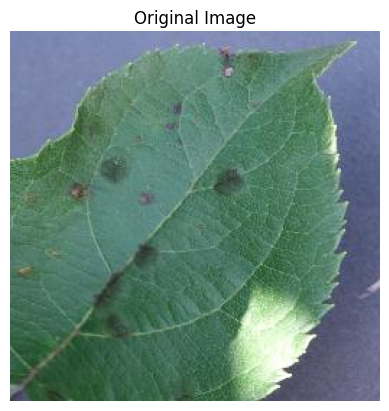

Transformed shape: torch.Size([3, 224, 224])
Transformed dtype: torch.float32
Min: -0.7804  Max: 1.0000
Label index: 0


In [5]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Lambda
from transformers import AutoImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Paths
DATA_DIR = "../data/split/test"
MODEL_DIR = "../models/vit-finetuned"

# Load processor
processor = AutoImageProcessor.from_pretrained(MODEL_DIR)

# Define transform
transform_fn = Compose([
    Lambda(lambda img: img.convert("RGB")),
    Lambda(lambda img: processor(images=img, return_tensors="pt")["pixel_values"].squeeze())
])

# Load test image
test_dataset = ImageFolder(DATA_DIR, transform=transform_fn)
original_dataset = ImageFolder(DATA_DIR)  # untransformed for visualization

# Sample image
index = 0
original_img, _ = original_dataset[index]
transformed_img, label = test_dataset[index]

# Show original image
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")
plt.show()

# Show tensor stats
print(f"Transformed shape: {transformed_img.shape}")
print(f"Transformed dtype: {transformed_img.dtype}")
print(f"Min: {transformed_img.min():.4f}  Max: {transformed_img.max():.4f}")
print(f"Label index: {label}")
